In [1]:
import tensorflow as tf
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys, gc
import skimage

plt.style.use('ggplot')
sys.path.insert(0,'..') # add parent directory to path
from prior_attention import build_prior_attentions
import utils
from config import Config

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers
from keras.optimizers import Adam

# this is important to make sure the Config is reloaded when modified
%load_ext autoreload
%autoreload 2
# %pprint

Using TensorFlow backend.


In [ ]:
all_res = utils.load_object('../cam/all_res.pkl')
all_map = utils.load_object('../cam/all_map.pkl')
all_inv_map = utils.load_object('../cam/all_inv_map.pkl')

In [2]:
def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

def print_proba_seq_results(proba_res, class_to_name_dict):
    for key, value in proba_res.items():
        print(key)
        print_proba_results(value, class_to_name_dict)
            
def print_proba_results(proba_res, class_to_name_dict):
    for i, proba in enumerate(proba_res):
        print(class_to_name_dict[proba[0]], proba[1])

In [67]:
keys_to_vis = ['ground_truth', 'first_prob', 'second_prob', 'correct', 'soft_heatmap']

key_to_title = {
    'ground_truth': 'Human attention - ground truth',
    'first_prob': 'CAM: Model\'s prediction (highest probability)',
    'second_prob': 'CAM: Model\'s second highest probability',
    'correct': 'CAM: Ground truth class',
    'soft_heatmap': 'Soft attention: heatmap'
}

def visualize(name, heatmap_results_list, class_map):    
    hm_results = heatmap_results_list[name]
    print("CAM prediction results:")
    print_proba_results(hm_results['prob_res'], class_map)
    
    print('')
    
    print("Soft attention prediction results:")
    print_proba_results(hm_results['soft_prob_res']['c'], class_map)
    
    for key in keys_to_vis:
        print('-------')
        print(key_to_title[key])
        hm_result = hm_results[key]
        heatmap = np.asarray(hm_result['hm'], np.float32)
        
        normalize=False
        if np.max(heatmap) < 1:
            normalize=True
        
        img, colorbar = overlay_heatmap(hm_results['image'], heatmap, 
                                        normalize=(normalize), absolute=True)
        plt.imshow(img, cmap='jet')
        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()
        if key == 'first_prob':
            print("Visualizing for:", class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Visualizing for:", class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if class_map[class_n] == name.split('_')[0]:
                    print("Visualizing for:", class_map[class_n])
        
        if key != 'ground_truth':
            print("Perason correlation with ground truth:", hm_result['pcc'])
        
        print('')
        
    

In [68]:
soft_res[name].keys()

dict_keys(['avg_heatmap', 'attention_vis', 'prob_res'])

In [102]:
cam_res = {name: value['cam_res'] for name, value in all_res.items()}
soft_res = {name: value['soft_res'] for name,value in all_res.items()}
# print(soft_res[name].keys())

for name, name_entries in soft_res.items():
    for step, att_dict in name_entries['attention_vis'].items():
        computer_img = att_dict['human'].copy()
        human_img = att_dict['computer'].copy()
        att_dict['human'] = human_img
        att_dict['computer'] = computer_img
            

CAM prediction results:
aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08

Soft attention prediction results:
aeroplane 0.93813497
boat 0.045088813
motorbike 0.007334693
bicycle 0.005315444
horse 0.0016120482
dog 0.0011533909
diningtable 0.0005088223
sofa 0.00038883314
cow 0.0003601627
cat 0.00010289001
-------
Human attention - ground truth


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


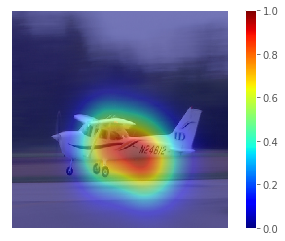


-------
CAM: Model's prediction (highest probability)


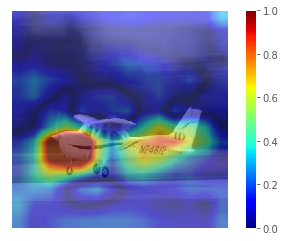

Visualizing for: aeroplane
Perason correlation with ground truth: 0.38003299934954676

-------
CAM: Model's second highest probability


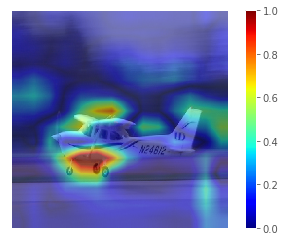

Visualizing for: boat
Perason correlation with ground truth: 0.2690754157959712

-------
CAM: Ground truth class


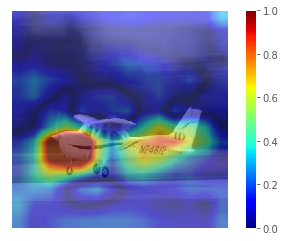

Visualizing for: aeroplane
Perason correlation with ground truth: 0.38003299934954676

-------
Soft attention: heatmap


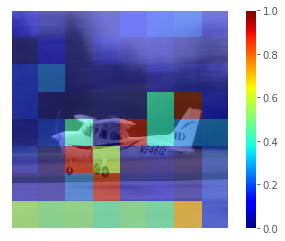

Perason correlation with ground truth: 0.20768018869444416



In [107]:
# add to cam_res to merge the heatmaps into one visualization
for key, value in cam_res.items():
    cam_res[key]['soft_heatmap'] = soft_res[key]['avg_heatmap']
    cam_res[key]['soft_prob_res'] = soft_res[key]['prob_res']

name = list(all_res.keys())[0]
visualize(name, cam_res, all_inv_map)

a
sofa 0.12636672
diningtable 0.104679346
bicycle 0.10065724
horse 0.099292904
cat 0.097962596
aeroplane 0.096587755
boat 0.09655828
dog 0.094253175
motorbike 0.09247996
cow 0.09116201
computer


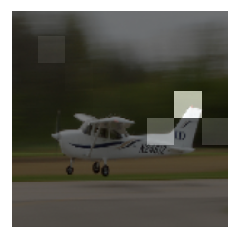

human


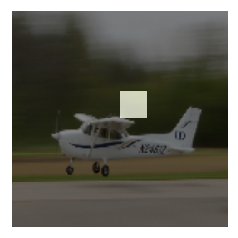

b
boat 0.13323486
dog 0.1311397
horse 0.12133151
cow 0.11162875
sofa 0.110925436
aeroplane 0.1043446
diningtable 0.07763397
cat 0.07704773
motorbike 0.06719679
bicycle 0.065516636
computer


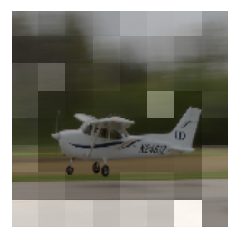

human


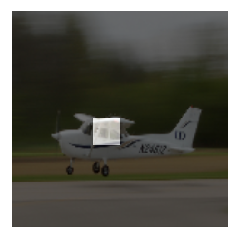

c
sofa 0.7391271
diningtable 0.14343625
horse 0.07076009
bicycle 0.01208579
dog 0.01207682
cow 0.011904756
boat 0.0045998124
aeroplane 0.0032715125
motorbike 0.0017767051
cat 0.0009612067
computer


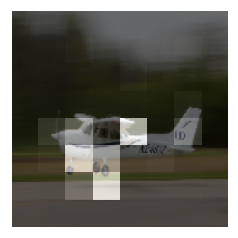

human


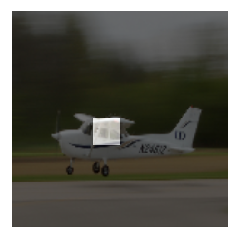

In [108]:
attention_vis = soft_res[name]['attention_vis']

for step, att_dict in attention_vis.items():
    print(step)
    print_proba_results(name_entries['prob_res'][step], all_inv_map)
    for subject, img in att_dict.items():
        print(subject)
        plt.imshow(np.asarray(img, np.float32))
        plt.grid(False)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()